### stat-RISMED program
Objective: To build a classification model to identify whether overseas regulatory action has been taken for a substandard medicine issue, based on the case description.
* Output of model will be used as input for stat-RISMED

#### Trial to use traditional ML methods

In [6]:
import re
import json
import pickle
import string
import numpy as np
import pandas as pd
import os

# import pkg_resources
# from symspellpy.symspellpy import SymSpell, Verbosity
# import spacy

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit

In [8]:
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\desmondteoch\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
# load full data
os.chdir(r"C:\Users\desmondteoch\Documents\CVU\Capstone\Impact Score")
data = pd.read_csv("Impact Score_2011tillJun2021_updated28Aug2021.csv", encoding="ISO-8859-1")

In [10]:
# select required columns only
overseas = data[["case_no","date_of_receipt","created_time","case_title","case_description",\
                "rismed_defect","rismed_defect_severity","rismed_overseas_action"]]
overseas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   case_no                 893 non-null    object
 1   date_of_receipt         893 non-null    object
 2   created_time            893 non-null    object
 3   case_title              893 non-null    object
 4   case_description        893 non-null    object
 5   rismed_defect           893 non-null    object
 6   rismed_defect_severity  893 non-null    object
 7   rismed_overseas_action  893 non-null    object
dtypes: object(8)
memory usage: 55.9+ KB


In [11]:
# recode "rismed_overseas_action" -- combine "Yes" and "Unknown" into one
overseas["label"] = overseas["rismed_overseas_action"].replace({"Yes": "Yes", "Unknown": "Yes",\
                                                                "No": "No"})
le = LabelEncoder()
overseas["label"] = le.fit_transform(overseas["label"])
print("Class distribution:\n",overseas.label.value_counts())
# 1: "Yes", 0: "No"

Class distribution:
 label
1    569
0    324
Name: count, dtype: int64


C:\Users\desmondteoch\AppData\Local\Temp\ipykernel_3348\2011588252.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overseas["label"] = overseas["rismed_overseas_action"].replace({"Yes": "Yes", "Unknown": "Yes",\
C:\Users\desmondteoch\AppData\Local\Temp\ipykernel_3348\2011588252.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overseas["label"] = le.fit_transform(overseas["label"])


In [12]:
overseas["text"] = overseas["case_description"]
overseas.head()

C:\Users\desmondteoch\AppData\Local\Temp\ipykernel_3348\3124874902.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overseas["text"] = overseas["case_description"]


,case_no,date_of_receipt,created_time,case_title,case_description,rismed_defect,rismed_defect_severity,rismed_overseas_action,label,text
0,SVS2011-000102,25/2/2009,2/6/2011,Certain batches of Hospira's Desferrioxamine m...,Certain batches of Hospira's Desferrioxamine m...,Product physical issue,Low,Yes,1,Certain batches of Hospira's Desferrioxamine m...
1,SVS2011-000354,10/3/2011,13/6/2011,NUH found some batches of Adrenaline 1:1000 in...,NUH found some batches of adrenaline 1:1000 in...,"Product expiration date missing, illegible or ...",Medium,Unknown,1,NUH found some batches of adrenaline 1:1000 in...
2,SVS2011-000368,19/4/2011,1/7/2011,Dimenate tablets failed specification for assay,Drug Houses of Australia (DHA) informed HSA th...,Out of specification or out of trend test result,Medium,Yes,1,Drug Houses of Australia (DHA) informed HSA th...
3,SVS2011-000374,16/11/2010,4/7/2011,Recall of specific lots of Ebetrexat 100mg/ml ...,EB had received two separate alerts from Austr...,Contamination with glass and/or metal particle,High,Yes,1,EB had received two separate alerts from Austr...
4,SVS2011-000381,5/1/2011,4/7/2011,Hundreds in UK become pregnant despite contrac...,Nearly 600 women in UK who used a popular cont...,Lack of efficacy,Medium,No,0,Nearly 600 women in UK who used a popular cont...


### Text cleaning

In [13]:
def text_clean(context):
    clean_lst = ["\r","\n","   ",'"',"'s",'\d']
    punctuation_signs = list(".?:!,;/\{[}]@#$%^&*(|)-�")
    for x in clean_lst:
        context = context.str.replace(x,'')
    for punct in punctuation_signs:
        context = context.str.replace(punct,' ')
    context = context.str.lower()
    return context

def stop_words(context):
    stop_words = list(stopwords.words('english'))
    for stop_word in stop_words:
        regex_stopword = r"\b" + stop_word + r"\b"
        context = context.str.replace(regex_stopword, '')
    for word in filter_words:
        regex_word = r"\b" + word + r"\b"
        context = context.str.replace(regex_word, '')
    return context
    
# filter_words = ['the','fda','us','usfda','hk','doh','ema','tga','taiwan','dh','es','pdr','canada','hsa','china','malaysia','singapore','germany','mg',
#                'ml','product','products','nbsp', 'warning letter','mah','company','please','uk']
filter_words = []

In [14]:
overseas["text"] = text_clean(overseas["text"])
overseas["text"] = stop_words(overseas["text"])

C:\Users\desmondteoch\AppData\Local\Temp\ipykernel_3348\3105994607.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overseas["text"] = text_clean(overseas["text"])
C:\Users\desmondteoch\AppData\Local\Temp\ipykernel_3348\3105994607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overseas["text"] = stop_words(overseas["text"])


In [15]:
# word count
from itertools import chain
unique_terms = overseas.text.str.split()
unique_terms = set(list(chain(*unique_terms)))
print('Count of unique terms:',len(unique_terms))

Count of unique terms: 16859


In [16]:
# extract 'text' and 'label' columns
X = overseas['text']
y = overseas['label']

In [17]:
# split into training/validation and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

print(f"Training data: {X_train.shape}\nTesting data: {X_test.shape}")

Training data: (714,)
Testing data: (179,)


In [13]:
# Parameter selection
ngram_range = (1,2)
min_df = 1
max_df = 0.9
max_features = 5000

# TF-IDF
tfidf = TfidfVectorizer(encoding='utf-8',
                       ngram_range=ngram_range,
                       stop_words=None,
                       lowercase=False,
                       max_df=max_df,
                       min_df=min_df,
                       max_features=max_features,
                       norm='l2',
                       sublinear_tf=True)

features_train = tfidf.fit_transform(X_train).toarray()
label_train = y_train
print(features_train.shape)

(714, 5000)


#### Use SMOTE to oversample negative classes

In [14]:
from imblearn.over_sampling import SMOTE
from collections import Counter

counter = Counter(label_train)
print('before:', counter)

smt = SMOTE(random_state = 8)
features_train, label_train = smt.fit_resample(features_train, label_train)

counter = Counter(label_train)
print('after:', counter)

before: Counter({1: 444, 0: 270})
after: Counter({0: 444, 1: 444})


#### BayesSearch to optimise hyperparameters

In [15]:
# !pip install scikit_optimize

In [16]:
from skopt import BayesSearchCV
from sklearn.svm import LinearSVC

# SVM
model = LinearSVC()
model_param={
    
    'loss':['hinge','squared_hinge'],
    'C':[10**x for x in range(-4,2)],
    'dual':[True],
    'penalty':['l2'],
    'max_iter': [100*x for x in range(1,10)]
    
}
                 
bayessearch_svm = BayesSearchCV(model, model_param, n_iter=32, cv=3)
bayessearch_svm.fit(features_train, label_train)
                 
print("The best hyperparameters from Bayes Search are: ")
print(bayessearch_svm.best_params_)
print("")
print("The mean accuracy score of a model with these hyperparameters is: ")
print(bayessearch_svm.best_score_)

C:\Users\desmondteoch\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\desmondteoch\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\desmondteoch\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\desmondteoch\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\desmondteoch\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\U

The best hyperparameters from Bayes Search are: 
OrderedDict([('C', 1.0), ('dual', True), ('loss', 'squared_hinge'), ('max_iter', 200), ('penalty', 'l2')])

The mean accuracy score of a model with these hyperparameters is: 
0.8186936936936937


In [27]:
model_svm = LinearSVC(loss='squared_hinge',
                      C=1.0,
                      #class_weight='balanced',
                      dual=True,
                      max_iter=200, 
                      penalty='l2',
                      random_state=8)
svm = CalibratedClassifierCV(model_svm) 
svm.fit(features_train, label_train)

# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(label_train, svm.predict(features_train)))
print(classification_report(label_train, svm.predict(features_train)))

features_test = tfidf.transform(X_test).toarray()
label_test = y_test
label_pred = svm.predict(features_test)
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(label_test, label_pred))

# Classification report
print("Classification report")
print(classification_report(label_test, label_pred))

The training accuracy is: 
0.9876126126126126
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       444
           1       0.98      1.00      0.99       444

    accuracy                           0.99       888
   macro avg       0.99      0.99      0.99       888
weighted avg       0.99      0.99      0.99       888

The test accuracy is: 
0.7262569832402235
Classification report
              precision    recall  f1-score   support

           0       0.57      0.39      0.46        54
           1       0.77      0.87      0.82       125

    accuracy                           0.73       179
   macro avg       0.67      0.63      0.64       179
weighted avg       0.71      0.73      0.71       179



In [18]:
from sklearn.linear_model import SGDClassifier

# SGD
model = SGDClassifier()
model_param={
    
    'loss':['hinge','log_loss','huber','modified_huber', 'perceptron'],
    'alpha':[10**x for x in range(-6,1)],
    'early_stopping': [False,True],
    'penalty':['l2','l1','elasticnet'],
    'max_iter': [100*x for x in range(1,15)],
    
}
                 
bayessearch_sgd = BayesSearchCV(model, model_param, n_iter=32, cv=3)
bayessearch_sgd.fit(features_train, label_train)
                 
print("The best hyperparameters from Bayes Search are: ")
print(bayessearch_sgd.best_params_)
print("")
print("The mean accuracy score of a model with these hyperparameters is: ")
print(bayessearch_sgd.best_score_)

The best hyperparameters from Bayes Search are: 
OrderedDict([('alpha', 1e-05), ('early_stopping', False), ('loss', 'huber'), ('max_iter', 500), ('penalty', 'l2')])

The mean accuracy score of a model with these hyperparameters is: 
0.8479729729729729


In [28]:
model_sgd = SGDClassifier(loss='huber',
                          alpha=0.00001,
                          early_stopping=False,
                          #class_weight='balanced',
                          max_iter=500, 
                          penalty='l2',
                          random_state=8)
sgd = CalibratedClassifierCV(model_sgd) 
sgd.fit(features_train, label_train)

# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(label_train, sgd.predict(features_train)))
print(classification_report(label_train, sgd.predict(features_train)))

features_test = tfidf.transform(X_test).toarray()
label_test = y_test
label_pred = sgd.predict(features_test)
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(label_test, label_pred))

# Classification report
print("Classification report")
print(classification_report(label_test, label_pred))

The training accuracy is: 
0.9988738738738738
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       444
           1       1.00      1.00      1.00       444

    accuracy                           1.00       888
   macro avg       1.00      1.00      1.00       888
weighted avg       1.00      1.00      1.00       888

The test accuracy is: 
0.7318435754189944
Classification report
              precision    recall  f1-score   support

           0       0.60      0.33      0.43        54
           1       0.76      0.90      0.82       125

    accuracy                           0.73       179
   macro avg       0.68      0.62      0.63       179
weighted avg       0.71      0.73      0.71       179



#### Save models

In [40]:
import pickle

with open('overseas_svm_model_030324.pkl','wb') as model_file:
    pickle.dump(svm, model_file)

#TF-IDF vectorizer
with open('overseas_TFIDF_vectorizer_030324.pkl','wb') as model_file:
    pickle.dump(tfidf, model_file)

In [41]:
import pickle

with open('overseas_sgd_model_030324.pkl','wb') as model_file:
    pickle.dump(sgd, model_file)

#TF-IDF vectorizer
with open('overseas_TFIDF_vectorizer_030324.pkl','wb') as model_file:
    pickle.dump(tfidf, model_file)

### For model inference on test set

In [5]:
import pickle
  
with open('overseas_sgd_model_030324.pkl','rb')as f1:
    sgd = pickle.load(f1)
    
with open('overseas_svm_model_030324.pkl','rb') as f2:
    svm = pickle.load(f2)

with open('overseas_TFIDF_vectorizer_030324.pkl','rb')as f3:
    tfidf = pickle.load(f3)

In [18]:
# Vectorize test data
features_test = tfidf.fit_transform(X_test).toarray()
label_test = y_test
print(features_test.shape)

(179, 5000)


In [19]:
# Get predictions and probabilities
sgd_label_pred = sgd.predict(features_test)
sgd_label_prob = sgd.predict_proba(features_test)[:, 1]

svm_label_pred = svm.predict(features_test)
svm_label_prob = svm.predict_proba(features_test)[:, 1]

In [20]:
# Print confusion matrix
sgd_conf_matrix = confusion_matrix(label_test, sgd_label_pred)
svm_conf_matrix = confusion_matrix(label_test, svm_label_pred)

print("SGD Confusion matrix:")
print(sgd_conf_matrix)
print()
print("SVM Confusion matrix:")
print(svm_conf_matrix)
#[[TN  FP]
# [FN  TP]]

SGD Confusion matrix:
[[  6  48]
 [ 10 115]]

SVM Confusion matrix:
[[  2  52]
 [  3 122]]


In [22]:
# Get AUC score
sgd_auc = roc_auc_score(y_test, sgd_label_prob)
svm_auc = roc_auc_score(y_test, svm_label_prob)

print("SGD AUC:", sgd_auc)
print("SVM AUC:", svm_auc)

SGD AUC: 0.5567407407407408
SVM AUC: 0.5668148148148148


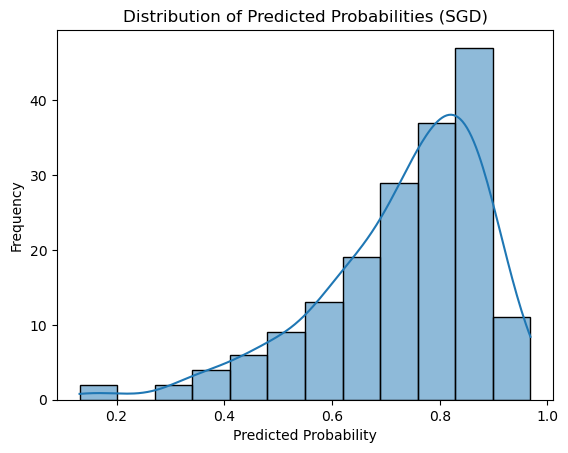

In [23]:
# Plot prediction probabilities for SGD
import seaborn as sns

sns.histplot(sgd_label_prob, kde=True)
plt.title('Distribution of Predicted Probabilities (SGD)')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

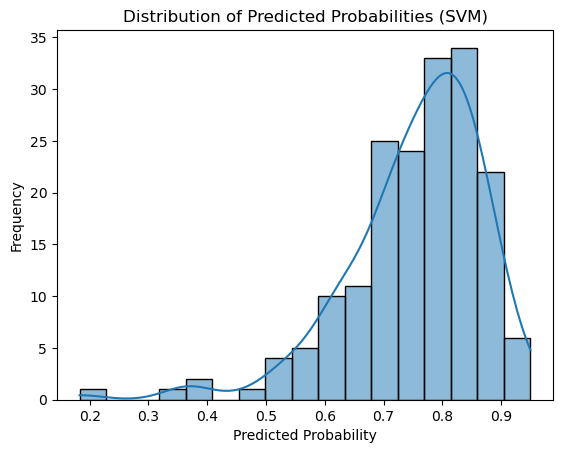

In [25]:
# Plot prediction probabilities for SVM
sns.histplot(svm_label_prob, kde=True)
plt.title('Distribution of Predicted Probabilities (SVM)')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

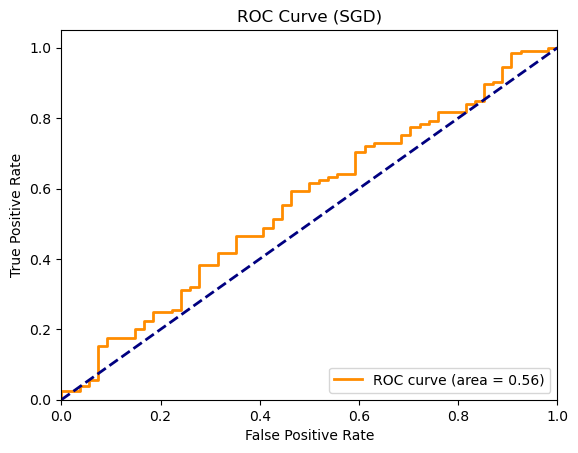

In [30]:
# Plot AUC curve for SGD
from sklearn.metrics import roc_curve, auc

sgd_fpr, sgd_tpr, sgd_thresholds = roc_curve(label_test, sgd_label_prob)

# Compute AUC
sgd_roc_auc = auc(sgd_fpr, sgd_tpr)

# Plot ROC curve
plt.figure()
plt.plot(sgd_fpr, sgd_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % sgd_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (SGD)')
plt.legend(loc="lower right")
plt.show()

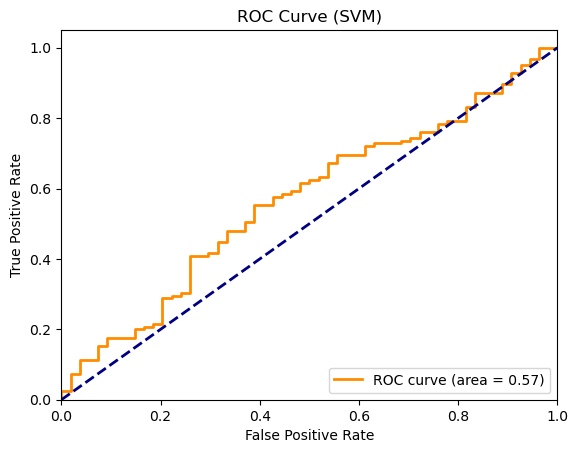

In [31]:
# Plot ROC curve for SVM
svm_fpr, svm_tpr, svm_thresholds = roc_curve(label_test, svm_label_prob)

# Compute AUC
svm_roc_auc = auc(svm_fpr, svm_tpr)

# Plot ROC curve
plt.figure()
plt.plot(svm_fpr, svm_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (SVM)')
plt.legend(loc="lower right")
plt.show()